## Zadanie 2

### Zadania teoretyczne
#### Wyjaśnić pojęcie ratingów, jakie poziomy ratingów stosują najbardziej znane agencje ratingowe?
Ratingi to jeden ze sposobów na ocenę poziomu ryzyka kredytowego, wystawiany przez agencje ratingowe dla dużych podmiotów na rynku. Określają one pewne przedziały prawdopodobieństwa niewypłacalności. Ratingi wystawiane są w postaci liter, główne agencje stosują oznaczenia AAA, AA, A, BBB, BB, B, CCC lub Aaa, Aa, A, Baa, Ba, B, Caa, w zależności od agencji. Oznaczenia podane są malejąco, tak więc rating AAA jest najlepszy i oznacza najmniejsze prawdopodobieństwo bankructwa, np. 1.5%, natomiast AA będzie od niego gorszy i może oznaczać prawdopodobieństwo bankructwa na poziomie np. 3.5%. 

#### Wyjaśnić ideę modelu CreditMetrics. Na czym on bazuje i w jaki sposób opisuje ryzyko kredytowe?
Model CreditMetrics jest modelem służącym do wyznaczania ryzyka kredytowego. Bazuje on na idei VaR, czyli maksymalnej spodziewanej stracie o danym prawdopodobieństwie i horyzoncie czasowym. CreditMetrics korzysta z niego aby przedstawić ryzyko, natomiast używa do tego różnych informacji, m.in. ratingów dla badanych podmiotów czy instrumentów, które dostarczają informacji o prawdopodobieństwie bankructwa i stopach zwrotu, czy tzw. seniority, które odpowiada za stopy odzysku w przypadku kiedy podmiot zbankrutuje i nie będzie w stanie spłacić swoich zobowiązań. 

### Zadanie praktyczne
Z wykorzystaniem modelu CreditMetrics wyznaczyć 99,9% VaR i ES dla portfela składającego się z portfela trzech poniżej opisanych obligacji skarbowych:

- 3-letnia obligacja o ratingu A (cena wykupu 100 000 zł, subordinated),
- 5-letnia obligacja o ratingu B (cena wykupu 50 000 zł, roczne kupony 5000 zł, senior secured),
- 2-letnia obligacja o ratingu CCC (cena wykupu 50 000 zł, roczne kupony 10 000 zł, senior unsecured).

W badaniu założyć, że współczynniki korelacji między inwestycjami w portfelu wynoszą: r12 = 0.2, r13 = 0.15, r23 = 0.4.

Zbadać, w jaki sposób zmieniłyby się wyniki, jeśli założylibyśmy, że inwestycje w portfelu nie są skorelowane. Jak uzyskane wyniki łączą się z pojęciem "dywersyfikacji ryzyka".
Na podstawie dokumentacji technicznej CreditMetrics na przykładzie opisać, jakie są sposoby wyznaczania korelacji w modelu.

W modelu CreditMetrics korelację w modelu można wyznaczyć poprzez połączenie korelacji między zmianami spreadów, czyli różnic między kursami sprzedaży i kupna obligacji, z modelem który łączy ceny z wydarzeniami kredytowymi. Aby tego dokonać należy posiadać wyżej wspomniany model oraz historię cen obligacji, z której to właśnie można obliczyć spready. Dzięki takiemu połączeniu specjaliści są w stanie dojść do korelacji między zmianami ratingów. Dla naszego zadania polegałoby to na znalezieniu historii cen każdej obligacji z osobna oraz obliczenie na jej podstawie spreadów. Następnie należałoby zbadać to jak spready razem się zmieniają i wyznaczyć korelację. Później trzeba zbudować odpowiedni model, który te zmiany odpowiednio zmapuje z wydarzeniami. Ostatecznie należy połączyć dwa poprzednie elementy.

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

W pierwszej kolejności wprowadzam dane potrzebne do rozwiązania zadania.

In [14]:
#macierz przejścia dla ratingów
mp = np.array([
    [93.40, 5.94, 0.64, 0.00, 0.02, 0.00, 0.00, 0.00],
    [1.61, 90.55, 7.46, 0.26, 0.09, 0.01, 0.00, 0.02],
    [0.07, 2.28, 92.44, 4.63, 0.45, 0.12, 0.01, 0.00],
    [0.05, 0.26, 5.51, 88.48, 4.76, 0.71, 0.08, 0.15],
    [0.02, 0.05, 0.42, 5.16, 86.91, 5.91, 0.24, 1.29],
    [0.00, 0.04, 0.13, 0.54, 6.35, 84.22, 1.91, 6.81],
    [0.00, 0.00, 0.00, 0.62, 2.05, 4.08, 69.20, 24.05],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 100.00]
])
mp = mp/100
mp = pd.DataFrame(mp, columns = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Def'],
                  index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Def'])

In [15]:
#macierz stóp zwrotu ogółem
msz = pd.DataFrame([[3.60, 4.17, 4.73, 5.12],
                    [3.65, 4.22, 4.78, 5.17],
                    [3.72, 4.32, 4.93, 5.32],
                    [4.10, 4.67, 5.25, 5.63],
                    [5.55, 6.02, 6.78, 7.27],
                    [6.05, 7.02, 8.03, 8.52],
                    [15.05, 15.02, 14.03, 13.52]],
                    columns = ['1Y', '2Y', '3Y', '4Y'],
                    index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
msz = msz/100

In [16]:
#stopa odzysku według klasy obligacji
data = {'Mean': [53.80, 51.13, 38.52, 32.74, 17.09],
        'SD': [26.86, 25.45, 23.81, 20.18, 10.90]}
mso = pd.DataFrame(data,index = ["Senior Secured", "Senior Unsecured",
                                 "Senior Subordinated", "Subordinated", "Junior Subordinated"])
mso = mso/100

In [17]:
#macierz korelacji 
mcorr = pd.DataFrame([[1.0, 0.2, 0.15],
                      [0.2, 1.0, 0.4],
                      [0.15, 0.4, 1.0]],
                      columns=['r1', 'r2', 'r3'],
                      index=['r1', 'r2', 'r3'])

Następnym krokiem będzie stworzenie kumulatywnej macierzy dla macierzy przejścia, dzięki której będę w stanie obliczyć przedziały dla losowanych scenariuszy.\
W każdym scenariuszu wylosowana zostanie liczba losowa z rozkładu normalnego, dlatego tutaj też wyznaczamy przedziały dla takiego rozkładu.

In [18]:
#stworzenie kumulatywnej macierzy przejścia
mp_cumulative = mp.cumsum(axis=1)
mp_cumulative = mp_cumulative.div(mp_cumulative.iloc[:, -1], axis=0)

#na podstawie kumulatywnej macierzy przejścia obliczamy macierz z-score
mp_z = mp_cumulative.copy()
mp_z = 1 - mp_z
mp_z = -st.norm.ppf(mp_z)
mp_z = pd.DataFrame(mp_z, columns=mp.columns, index=mp.index)

Następnie definiuję funkcje służące do wyceny obligacji. Obligacje mogą być również zero-kuponowe, dlatego potrzebuję dwóch osobnych funkcji do obliczania wartości poszczególnych typów obligacji.

In [19]:
#definiujemy funkcje służące do wyceny obligacji z kuponami i bez kuponów
#bez kuponów
def bond_valuation_nc(value, msz, maturity, rating):
    return value/(1+msz.loc[rating, '{}Y'.format(maturity-1)])
#z kuponami
def bond_valuation_c(value, msz, maturity, coupon, rating):
    return np.sum([coupon / (1 + msz.loc[rating,'{}Y'.format(maturity-1)]) ** i for i in range(2, maturity + 1)]) + (value / (1 + msz.loc[rating,'{}Y'.format(maturity-1)]) ** maturity)

Wprowadzam dane o odpowiednich obligacjach z zadania.

In [20]:
#wprowadzamy dane o obligacjach z zadania
valA = 100000 #subordinated, 3-letnia, bez kuponów
valB = 50000 #senior secured, 5-letnia
couponB = 5000
valCCC = 50000 #senior unsecured, 2-letnia
couponCCC = 10000

Z użyciem zdefiniowanych wcześniej funkcji, wyznaczam wartość portfela przy założeniu, że żaden z ratingów nie zmieni się w ciągu roku.

In [21]:
#wycena portfela bez zmiany ratingu
portfolio_value = bond_valuation_nc(valA, msz, 3, 'A') + bond_valuation_c(valB, msz, 5, couponB, 'B') + bond_valuation_c(valCCC, msz, 2, couponCCC, 'CCC')
print('Wartość portfela bez zmiany ratingu: {:.2f} zł'.format(portfolio_value))

Wartość portfela bez zmiany ratingu: 189495.20 zł


Następnie symuluję scenariusze.\
Z rozkładu normalnego losuję liczby i tworzę z nich macierz.\
Następnie na podstawie wyznaczonej wcześniej macierzy z-score wyznaczam przedziały odpowiadające zmianie na odpowiednie ratingi.\
Bazując na powyższych przedziałach przypisuję końcowe ratingi dla symulowanych scenariuszy.\
Dla każdego "bazowego" ratingu, czyli tego od którego wychodzimy na początku, przedziały będą inne ponieważ szanse zmiany na inne ratingi różnią się dla każdego ratingu.

In [22]:
# Symulacja scenariuszy
#np.random.seed(123)
num_scenarios = 10000
#losujemy liczby losowe z rozkładu normalnego o zadanej macierzy korelacji
scenarios = np.random.multivariate_normal(mean=np.zeros(len(mcorr)), cov=mcorr, size=num_scenarios)
scenarios = pd.DataFrame(scenarios, columns=["Obligacja1","Obligacja2","Obligacja3"])

#wprowadzamy przedziały dla z-score odpowiadające zmianom ratingów
value_rangeA = [-float('inf'),-3.19, -1.99, 1.63, 2.52, 3.01, 3.72, 3.73, float('inf')]
value_rangeB = [-float('inf'),-3.5, -3.35, -2.93, -2.45, -1.47, 1.36, 1.49, float('inf')]
value_rangeCCC = [-float('inf'),-4, -3.5, -3, -2.50, -1.93, -1.49, 0.70, float('inf')]
letters = ['Def', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']
letters = letters[::-1]

#na podstawie wyznaczonych przedziałów przypisujemy ratingi do scenariuszy
scenarios['OblA'] = pd.cut(scenarios['Obligacja1'], bins=value_rangeA, labels=letters)
scenarios['OblB'] = pd.cut(scenarios['Obligacja2'], bins=value_rangeB, labels=letters)
scenarios['OblCCC'] = pd.cut(scenarios['Obligacja3'], bins=value_rangeCCC, labels=letters)
scenarios = scenarios[['OblA', 'OblB', 'OblCCC']]

Przed rozpoczęciem obliczania wartości zasymulowanych portfeli definiuję funkcję, która pozwoli obsłużyć nam przypadek, w którym końcowy rating oznacza bankructwo.\
W przypadku bankructwa funkcja przyjmuje typ obligacji i na jego podstawie losuje procentowy zwrot ceny korzystając z rozkładu normalnego o odpowiedniej średniej i odchyleniu standardowym.

In [23]:
#definiujemy funkcję która zwraca wartość obligacji w przypadku bankructwa
def value_when_bankrupt(value, seniority):
    val = value * np.random.normal(mso.loc[seniority, 'Mean'], (mso.loc[seniority, 'SD']))
    if(val<0):
        return -val
    else:
        return val

Wykorzystując powyższe funkcje wyznaczamy wartości kolejnych obligacji dla wylosowanych scenariuszy.\
Najpierw sprawdzamy czy końcowym ratingiem nie jest "Def" odpowiadający za bankructwo. Jeśli tak, zwracamy wartość obliczoną na podstawie wylosowanej stopy odzysku.\
W przeciwnym wypadku wyceniamy obligację.\
Następnie obliczam całkowitą wartość portfela oraz różnicę od portfela bazowego (bez jakiejkolwiek zmiany ratingu).

In [24]:
#przypisujemy wartości obligacji w zależności od ratingu dla scenariuszy
scenarios['Valuation_A'] = scenarios.apply(lambda column: value_when_bankrupt(valA, 'Subordinated') if column['OblA'] == 'Def' else bond_valuation_nc(valA, msz, 3, column['OblA']), axis=1)
scenarios['Valuation_B'] = scenarios.apply(lambda column: value_when_bankrupt(valB, 'Senior Secured') if column['OblB'] == 'Def' else bond_valuation_c(valB, msz, 5, couponB, column['OblB']), axis=1)
scenarios['Valuation_CCC'] = scenarios.apply(lambda column: value_when_bankrupt(valCCC, 'Senior Unsecured') if column['OblCCC'] == 'Def' else bond_valuation_c(valCCC, msz, 2, couponCCC, column['OblCCC']), axis=1)
#obliczamy całkowitą wartość portfela dla każdego scenariusza
scenarios["Portfolio Value"] = scenarios['Valuation_A'] + scenarios['Valuation_B'] + scenarios['Valuation_CCC']
#obliczamy różnicę między wartością portfela w scenariuszu a wartością portfela bez zmiany ratingu
scenarios["Portfolio Diff"] =  portfolio_value - scenarios["Portfolio Value"]
differences = scenarios["Portfolio Diff"]

Na podstawie rozkładu strat wyliczonych powyżej, wyznaczam 99,9% VaR oraz ES.

In [25]:
#obliczamy VaR oraz ES
var = differences.quantile(0.999)
print("99.9% VaR wynosi {:.2f}".format(var))

cvar = differences[differences >= var].quantile(0.999)
print("99.9% ES wynosi {:.2f}".format(cvar))


99.9% VaR wynosi 76262.64
99.9% ES wynosi 89536.99


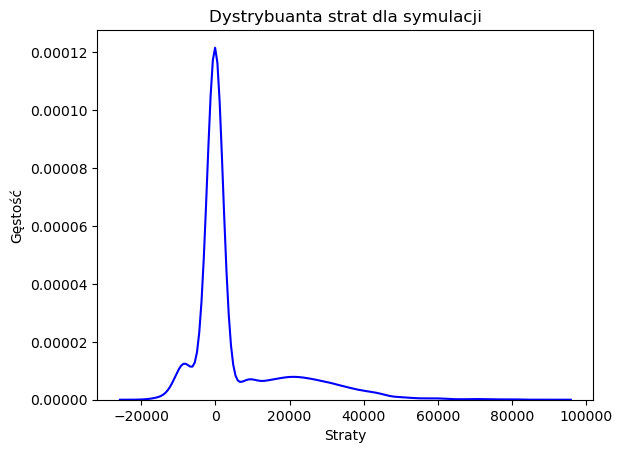

In [26]:
sns.kdeplot(differences, color='blue')
plt.xlabel('Straty')
plt.ylabel('Gęstość')
plt.title('Dystrybuanta strat dla symulacji')
plt.show()

Jak widać na powyższym wykresie zasymulowane straty faktycznie można uznać za przypominające sytuację rzeczywistą. Większość z nich skupia się wokół 0, natomiast prawy ogon jest zdecydowanie bardziej wydłużony niż ogon lewy. Oznacza to, że obniżenie ratingu następowało częściej niż jego podniesienie. Ponadto wysokie straty spowodowane są udziałem ratingu CCC, który ma wysokie prawdopodobieństwo spadku na poziom bankructwa (trochę powyżej 24%), przez co brana pod uwagę jest jedynie stopa odzysku z całej obligacji.

Aby porównać wyniki symulacji z wykorzystaniem macierzy korelacji i bez jej wykorzystania, przeprowadzę kolejną symulację.\
Powyższy algorytm wykonam 1000 razy i stworzę rozkład otrzymanych współczynników ryzyka.\
Następnie 1000 razy przeprowadzę analogiczny algorytm ale bez uwzględniania macierzy korelacji.

In [33]:
vars_corr = []
cvars_corr = []
for i in range(1000):
    num_scenarios = 1000
    scenarios = np.random.multivariate_normal(mean=np.zeros(len(mcorr)), cov=mcorr, size=num_scenarios)
    scenarios = pd.DataFrame(scenarios, columns=["Obligacja1","Obligacja2","Obligacja3"])

    scenarios['OblA'] = pd.cut(scenarios['Obligacja1'], bins=value_rangeA, labels=letters)
    scenarios['OblB'] = pd.cut(scenarios['Obligacja2'], bins=value_rangeB, labels=letters)
    scenarios['OblCCC'] = pd.cut(scenarios['Obligacja3'], bins=value_rangeCCC, labels=letters)
    scenarios = scenarios[['OblA', 'OblB', 'OblCCC']]

    scenarios['Valuation_A'] = scenarios.apply(lambda column: value_when_bankrupt(valA, 'Subordinated') if column['OblA'] == 'Def' else bond_valuation_nc(valA, msz, 3, column['OblA']), axis=1)
    scenarios['Valuation_B'] = scenarios.apply(lambda column: value_when_bankrupt(valB, 'Senior Secured') if column['OblB'] == 'Def' else bond_valuation_c(valB, msz, 5, couponB, column['OblB']), axis=1)
    scenarios['Valuation_CCC'] = scenarios.apply(lambda column: value_when_bankrupt(valCCC, 'Senior Unsecured') if column['OblCCC'] == 'Def' else bond_valuation_c(valCCC, msz, 2, couponCCC, column['OblCCC']), axis=1)
    scenarios["Portfolio Value"] = scenarios['Valuation_A'] + scenarios['Valuation_B'] + scenarios['Valuation_CCC']
    scenarios["Portfolio Diff"] =  portfolio_value - scenarios["Portfolio Value"]
    differences = scenarios["Portfolio Diff"]

    var = differences.quantile(0.999)
    cvar = differences[differences >= var].quantile(0.999)

    vars_corr.append(var)
    cvars_corr.append(cvar)
correlation_results = pd.DataFrame({'VaR': vars_corr, 'ES': cvars_corr})

vars_nocorr = []
cvars_nocorr = []
for i in range(1000):
    num_scenarios = 1000
    scenarios = np.random.multivariate_normal(mean=np.zeros(3), cov=np.eye(3), size=num_scenarios)
    scenarios = pd.DataFrame(scenarios, columns=["Obligacja1","Obligacja2","Obligacja3"])

    scenarios['OblA'] = pd.cut(scenarios['Obligacja1'], bins=value_rangeA, labels=letters)
    scenarios['OblB'] = pd.cut(scenarios['Obligacja2'], bins=value_rangeB, labels=letters)
    scenarios['OblCCC'] = pd.cut(scenarios['Obligacja3'], bins=value_rangeCCC, labels=letters)
    scenarios = scenarios[['OblA', 'OblB', 'OblCCC']]

    scenarios['Valuation_A'] = scenarios.apply(lambda column: value_when_bankrupt(valA, 'Subordinated') if column['OblA'] == 'Def' else bond_valuation_nc(valA, msz, 3, column['OblA']), axis=1)
    scenarios['Valuation_B'] = scenarios.apply(lambda column: value_when_bankrupt(valB, 'Senior Secured') if column['OblB'] == 'Def' else bond_valuation_c(valB, msz, 5, couponB, column['OblB']), axis=1)
    scenarios['Valuation_CCC'] = scenarios.apply(lambda column: value_when_bankrupt(valCCC, 'Senior Unsecured') if column['OblCCC'] == 'Def' else bond_valuation_c(valCCC, msz, 2, couponCCC, column['OblCCC']), axis=1)
    scenarios["Portfolio Value"] = scenarios['Valuation_A'] + scenarios['Valuation_B'] + scenarios['Valuation_CCC']
    scenarios["Portfolio Diff"] =  portfolio_value - scenarios["Portfolio Value"]
    differences = scenarios["Portfolio Diff"]

    var = differences.quantile(0.999)
    cvar = differences[differences >= var].quantile(0.999)

    vars_nocorr.append(var)
    cvars_nocorr.append(cvar)
no_correlation_results = pd.DataFrame({'VaR': vars_nocorr, 'ES': cvars_nocorr})

Po przeprowadzeniu symulacji porównam otrzymane rozkłady VaR i ES. W pierwszej kolejności spójrzmy na VaR.

In [55]:
results = pd.DataFrame(np.array([[no_correlation_results['VaR'].mean(), no_correlation_results['VaR'].median(), no_correlation_results['VaR'].std()],
                                [correlation_results['VaR'].mean(), correlation_results['VaR'].median(), correlation_results['VaR'].std()]]),
                      columns=['Mean', 'Median', 'Std'], index=['Bez korelacji', 'Z korelacją'])
print(results)


                       Mean        Median          Std
Bez korelacji  63777.448755  63613.676974  7597.573905
Z korelacją    70738.259711  70742.316190  5761.236382


Jak widać powyżej, w przypadku symulacji z korelacją wyniki VaR średnio są wyższe. Sama wartość jest tutaj trudna do interpretacji, ponieważ wyższy VaR może być tak lepszy (np. pozwala lepiej się zabezpieczyć) jak i gorszy (np. powoduje niepotrzebną akumulację środków które zamiast tego mogłyby pracować). Dla opcji z korelacją niższe jest natomiast odchylenie standardowe, które oznacza że taki wariant jest dokładniejszy i mniej się waha. Wyższe wartości wskazują jednak na to, że wysoka korelacja między obligacjami może negatywnie wpływać na straty, ponieważ kiedy spada jeden z ratingów pozostałe mają na to większa szansę. Jest to jednak też miecz obosieczny, ponieważ działa to analogicznie w przypadku zysków przy podwyższeniu ratingu. Bezpośrednio łączy się to z pojęciem "dywersyfikacji ryzyka", które oznacza de facto inwestowanie w różne, możliwie słabo zkorelowane ze sobą instrumenty. Dzięki takiemu postępowaniu nie narażamy się na ryzyko, że wszystkie nasze inwestycje w jednakowym czasie staną się niewypłacalne i stracimy środki.  

In [57]:
results = pd.DataFrame(np.array([[no_correlation_results['ES'].mean(), no_correlation_results['ES'].median(), no_correlation_results['ES'].std()],
                                [correlation_results['ES'].mean(), correlation_results['ES'].median(), correlation_results['ES'].std()]]),
                      columns=['Mean', 'Median', 'Std'], index=['Bez korelacji', 'Z korelacją'])
print(results)

                       Mean        Median          Std
Bez korelacji  71396.579689  70952.578249  9254.034242
Z korelacją    77274.986107  76542.799832  8454.946885


W przypadku ES oczywiście sytuacja ma się analogicznie.